In [3]:
from lib.utils import load_raw_list
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import os

from torch import nn
from torch.nn.functional import relu,one_hot
from sklearn.model_selection import train_test_split
from lib.datasets import WindowedEEGDataset
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt

device = 'cuda'
data_dir = 'data/w1'

In [4]:
train_idx,dev_idx = train_test_split(range(len(os.listdir(data_dir))),test_size=.2,shuffle=True,random_state=0)

In [5]:
trainloader = DataLoader(WindowedEEGDataset(data_dir,train_idx),batch_size=128,shuffle=True)
devloader = DataLoader(WindowedEEGDataset(data_dir,dev_idx),batch_size=128,shuffle=True)

In [10]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(5000,10)
        self.fc2 = nn.Linear(10,3)
    def forward(self,x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x

In [11]:
model = MLP().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [12]:
loss_tr = []
loss_dev = []

In [15]:
project_dir = 'w1'

os.makedirs(project_dir)

In [17]:
for i in tqdm(range(100)):
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))
    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))

    # plot recent loss
    plt.plot(loss_tr[-30:])
    plt.plot(loss_dev[-30:])
    plt.savefig(f'{project_dir}/loss.jpg')
    plt.close()

    # plot all loss
    plt.plot(loss_tr)
    plt.plot(loss_dev)
    plt.savefig(f'{project_dir}/curr_loss.jpg')
    plt.close()

    # print stats
    print(f'Epoch {i} Train: {loss_tr_total/len(trainloader)} Dev: {loss_dev_total/len(devloader)}')

    # save on checkpoint
    if(i%10 == 0):
        torch.save(model,f'{project_dir}/{i}.pt')

  1%|          | 1/100 [00:29<48:59, 29.69s/it]

Epoch 0 Train: 0.8694278074911347 Dev: 0.8633480832256653


  2%|▏         | 2/100 [00:58<47:29, 29.07s/it]

Epoch 1 Train: 0.862088685337868 Dev: 0.8630739386986803


  3%|▎         | 3/100 [01:26<46:39, 28.86s/it]

Epoch 2 Train: 0.8619978654853724 Dev: 0.8630427878212046


  4%|▍         | 4/100 [01:54<45:35, 28.50s/it]

Epoch 3 Train: 0.8620198202077989 Dev: 0.8630712713908266


  5%|▌         | 5/100 [02:23<45:09, 28.52s/it]

Epoch 4 Train: 0.8620103060578307 Dev: 0.8630335155736517


  6%|▌         | 6/100 [02:52<44:54, 28.66s/it]

Epoch 5 Train: 0.8619754031576492 Dev: 0.8630441242346057


  7%|▋         | 7/100 [03:21<44:49, 28.92s/it]

Epoch 6 Train: 0.8620022479099808 Dev: 0.8630398691252426


  8%|▊         | 8/100 [03:51<44:31, 29.03s/it]

Epoch 7 Train: 0.8619745174353873 Dev: 0.8630499170610199


  8%|▊         | 8/100 [04:19<49:44, 32.44s/it]


KeyboardInterrupt: 

100%|██████████| 14/14 [00:00<00:00, 60.01it/s]


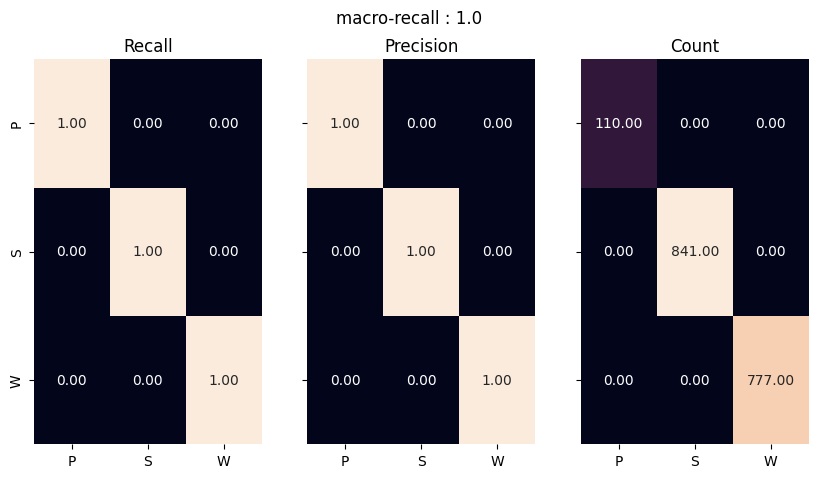

In [7]:
from lib.utils import *

model = torch.load('2400.pt').cpu()
data_dir = 'w1_0_unbal'

train_idx,dev_idx = train_test_split(range(len(os.listdir(data_dir))),test_size=.2,shuffle=True,random_state=0)

devloader = DataLoader(WindowedEEGDataset(data_dir,dev_idx),batch_size=128,shuffle=True)
# # test confusion matrices
y_true = torch.Tensor()
y_pred = torch.Tensor()
for (X,y) in tqdm(devloader):
    y_true = torch.cat([y_true,y.argmax(axis=1)])
    y_pred = torch.cat([y_pred,torch.softmax(model(X),dim=1).argmax(axis=1)])
y_pred = y_pred
cms(y_true=y_true,y_pred=y_pred,current_date=None)